# 1. Setup

## 1.1 Install Dependencies

In [ ]:
#docker pull tensorflow/tensorflow:2.17.0rc0-jupyter
#docker run -it --rm -v $(realpath ~/notebooks):/tf/notebooks -p 8888:8888 tensorflow/tensorflow:2.17.0rc0-jupyter
#docker run -it --rm -v $(realpath ~/notebooks):/tf/notebooks -p 8888:8888 tensorflow/tensorflow:latest-jupyter

In [2]:
!pip install tensorflow opencv-python matplotlib

## 1.2 Import Dependencies

In [3]:
# Import standard dependencies
import cv2
import os
import random
import uuid
import numpy as np
from matplotlib import pyplot as plt

# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [8]:
print(f"{len(tf.config.list_physical_devices('GPU'))}, people are coming to the party")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available")
    # Avoid OOM errors by setting GPU Memory Consumption Growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus: 
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("GPU is not available")

0, people are coming to the party
GPU is not available


## 1.4 Create Folder Structures

In [9]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')
APP_PATH = os.path.join('application_data', 'verification_images')
APPV_PATH = os.path.join('application_data', 'input_image')

In [10]:
# Make the directories
if not os.path.exists(POS_PATH):
    os.makedirs(POS_PATH)
if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)
if not os.path.exists(ANC_PATH):
    os.makedirs(ANC_PATH)
if not os.path.exists(APP_PATH):
    os.makedirs(APP_PATH)
if not os.path.exists(APPV_PATH):
    os.makedirs(APPV_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [11]:
# http://vis-www.cs.umass.edu/lfw/

In [12]:
MINIMUM_SIZE = 200

file_count = 0
for entry in os.scandir(NEG_PATH):
    if entry.is_file():
        file_count += 1
    if file_count == MINIMUM_SIZE:
        break
        # Uncompress Tar GZ Labelled Faces in the Wild Dataset

enough_files = (file_count == MINIMUM_SIZE)

if ( file_count < MINIMUM_SIZE ):
    print( " lfw.tgz was not extracted before: "+ str(file_count) + " in "+ NEG_PATH)
    print( " extracting lfw.tgz")
    !tar -xf lfw.tgz
    # Move LFW Images to the following repository data/negative
    print( " moving extracted lfw.tgz files to NEG_PATH")
    for directory in os.listdir('lfw'):
        for file in os.listdir(os.path.join('lfw', directory)):
            EX_PATH = os.path.join('lfw', directory, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)
elif ( file_count == MINIMUM_SIZE):
    print( " lfw.tgz was previously extracted: " + str(len([name for name in os.listdir(NEG_PATH) if os.path.isfile(os.path.join(NEG_PATH, name))])) )


 lfw.tgz was previously extracted: 13233


## 2.2 Collect Positive and Anchor Classes

In [13]:
WEBCAM=1

In [14]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid4().int))

'data\\anchor\\228025070743157212807013565690083000904.jpg'

In [15]:
# Initialize the webcam
cap = cv2.VideoCapture(WEBCAM)
positive_input=0
anchor_input=0
try:
    while cap.isOpened(): 
        ret, frame = cap.read()
        
        if not ret:
            print("Failed to grab frame")
            break
        
        # Cut down frame to 250x250px
        frame = frame[120:120+250,200:200+250, :]
        
        # Collect anchors 
        if cv2.waitKey(1) & 0xFF == ord('a'):
            # Create the unique file path 
            imgname = os.path.join(ANC_PATH, '{}.jpg'.format(int(uuid.uuid4().int)))
            # Write out anchor image
            cv2.imwrite(imgname, frame)
            anchor_input=anchor_input+1
            print("anchor count: " + str(anchor_input))
        
        # Collect positives
        if cv2.waitKey(1) & 0xFF == ord('p'):
            # Create the unique file path 
            imgname = os.path.join(POS_PATH, '{}.jpg'.format(int(uuid.uuid4().int)))
            # Write out positive image
            cv2.imwrite(imgname, frame)
            positive_input=positive_input+1
            print("positive count: " + str(positive_input))

        # Show image back to screen
        cv2.imshow('Image Collection', frame)
        
        # Breaking gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # Release the webcam
    cap.release()
    # Close the image show frame
    cv2.destroyAllWindows()

anchor count: 1
anchor count: 2
positive count: 1
positive count: 2
positive count: 3
positive count: 4
positive count: 5
positive count: 6
anchor count: 3
anchor count: 4
anchor count: 5
anchor count: 6
positive count: 7
anchor count: 7
anchor count: 8
anchor count: 9
positive count: 8
anchor count: 10
anchor count: 11
anchor count: 12
positive count: 9
anchor count: 13
positive count: 10
anchor count: 14
anchor count: 15
anchor count: 16
anchor count: 17


imgname: data\anchor\135438618294855510524337831581252606035.jpg


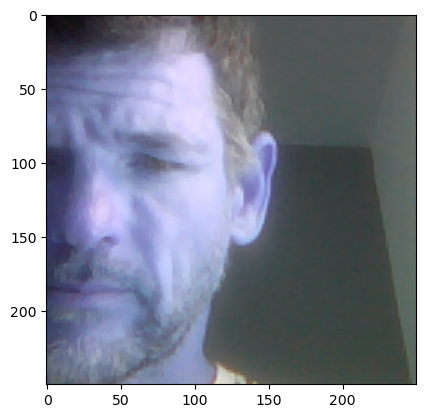

In [16]:
import glob
from pathlib import Path
try:
    frame
except NameError:
    print("frame is NOT defined yet!")
else:
    plt.imshow(frame)

# Undefine the variable
#del imgname

try:
    imgname
except NameError:
    print("imgname is NOT defined yet!")
    folder_path = Path(os.path.join(ANC_PATH))
    print("looking in: " + str(folder_path))
    list_of_paths = list(folder_path.glob('*.jpg'))
    if list_of_paths:
        latest_file = max(list_of_paths, key=lambda p: p.stat().st_ctime)
        print("latest file: " + str(latest_file))
        imgname = os.path.join(latest_file)
        print("imgname set to: " + str(imgname))
    else:
        print("No .jpg files found in " + ANC_PATH)
else:
    print("imgname: " + str(imgname))


# 2.x Data Augmentation

In [251]:
def data_aug(img):
    dataset = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        dataset.append(img)
    
    return dataset

# 3. Load and Preprocess Images

In [18]:
img_path = imgname
print('image path:' +str(img_path))
img = cv2.imread(img_path)


image path:data\anchor\135438618294855510524337831581252606035.jpg


In [19]:
augmented_images = data_aug(img)
for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(int(uuid.uuid4() ) )), image.numpy() )


## 3.1 Get Image Directories

In [250]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [252]:
dir_test_anchor = anchor.as_numpy_iterator()
dir_test_positive = positive.as_numpy_iterator()
dir_test_negative = negative.as_numpy_iterator()

In [253]:
print(dir_test_anchor.next())
print(dir_test_positive.next())
print(dir_test_negative.next())

b'data\\anchor\\36272694203876579878255181922236055648.jpg'
b'data\\positive\\321874491770023244855786789189471783314.jpg'
b'data\\negative\\Leticia_Dolera_0001.jpg'


## 3.2 Preprocessing - Scale and Resize

In [254]:
import tensorflow as tf

def preprocess(file_path):
    # Ensure file_path is converted to string tensor
    if isinstance(file_path, bytes):
        file_path = tf.convert_to_tensor(file_path, dtype=tf.string)
    elif isinstance(file_path, tf.Tensor):
        file_path = tf.cast(file_path, tf.string)

    # Read in the image from file path
    byte_img = tf.io.read_file(file_path)
    # Decode the image
    img = tf.io.decode_jpeg(byte_img, channels=3)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100, 100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return the processed image
    return img


In [255]:
print('preprocessing file: ' + str(imgname))
img = preprocess(imgname)

preprocessing file: data\anchor\135438618294855510524337831581252606035.jpg


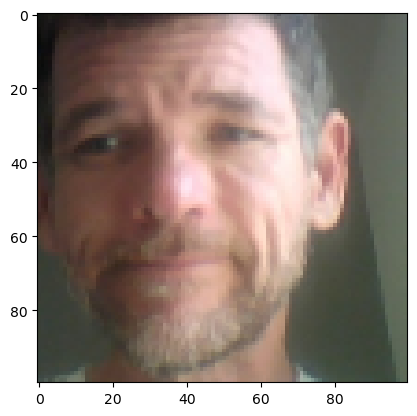

In [256]:
img.numpy().max() 
plt.imshow(img)

In [257]:
# dataset.map(preprocess)

## 3.3 Create Labelled Dataset

In [258]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [259]:
#creating labeled dataset
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
dataset = []
dataset = positives.concatenate(negatives)
#dataset = negatives.concatenate(positives)


In [260]:
print(' there are ' + str(tf.ones(len(anchor)).shape[0]) + ' ones in ' + ANC_PATH)
print(' there are ' + str(tf.ones(len(positive)).shape[0]) + ' ones in ' + POS_PATH)
print(' there are ' + str(tf.zeros(len(negative)).shape[0]) + ' zeros in ' + NEG_PATH)

 there are 300 ones in data\anchor
 there are 300 ones in data\positive
 there are 300 zeros in data\negative


In [261]:
samples = dataset.as_numpy_iterator()

In [262]:
example = samples.next()

In [263]:
#example

In [264]:
len(dataset)

600

## 3.4 Build Train and Test Partition

In [265]:
# this basically takes:
# (b'data\\anchor\\71636906539880418712600979738986621799.jpg',
#  b'data\\positive\\149034039615166075668887512147981363189.jpg',
#  1.0)
# and preprocesses them
def preprocess_twin(input_img, validation_img, label):
    return preprocess(input_img), preprocess(validation_img), label

In [266]:
res = preprocess_twin(*example)

print(' returns ' + str(len(res)) + ' items')
print(' a ' + str(res[0].shape) + ' shape')
print(' a ' + str(res[1].shape) + ' shape')
print('and a label of ' + str(res[2]))


 returns 3 items
 a (100, 100, 3) shape
 a (100, 100, 3) shape
and a label of 1.0


 plot the 0


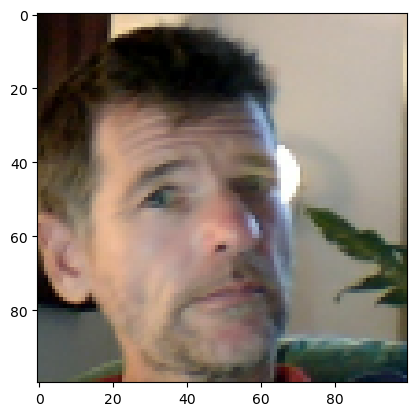

In [267]:
# which we can plot
print(' plot the 0')
plt.imshow(res[0])

 plot the 1


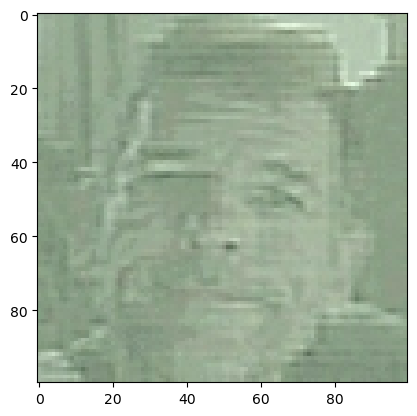

In [268]:
print(' plot the 1')
plt.imshow(res[1])

In [269]:
input_img, validation_img, label = example
#regular_string = byte_string.decode('utf-8')

print(input_img.decode('utf-8'))   # b'data\\anchor\\127470327868448223408149513670085446674.jpg'
print(validation_img.decode('utf-8')) # b'data\\positive\\1634237672113708953579402914796074059.jpg'
print(label)   # 1.0


data\anchor\96778838005883879655437142533825768467.jpg
data\positive\5443606487174055696352565280692233488.jpg
1.0


In [270]:
# Unpack the tuple
anchor_path, positive_path, label = example

# Convert the byte strings to regular strings (if needed)
anchor_path = anchor_path.decode('utf-8')
positive_path = positive_path.decode('utf-8')

# Print the results
print("Anchor Path:", anchor_path)
print("Positive Path:", positive_path)
print("Label:", label)

Anchor Path: data\anchor\96778838005883879655437142533825768467.jpg
Positive Path: data\positive\5443606487174055696352565280692233488.jpg
Label: 1.0


In [271]:
# Build dataloader pipeline
dataset = dataset.map(preprocess_twin)
# # Check the output
#for input_img, validation_img, label in data.take(1):
#    print("Input Image:", input_img)
#    print("Validation Image:", validation_img)
#    print("Label:", label)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1024)
# when passing dataset to the trainer, we need a mixed set

In [272]:
samples = []

In [273]:
samples = dataset.as_numpy_iterator()

In [274]:
samp2 = samples.next()

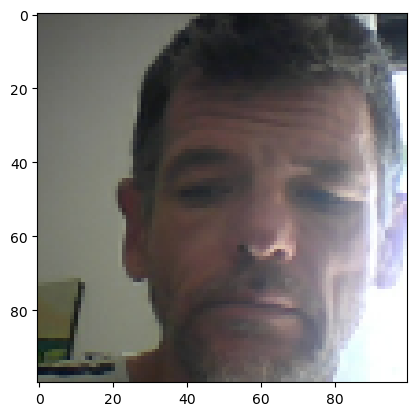

In [275]:
plt.imshow(samp2[0]) # anchor image

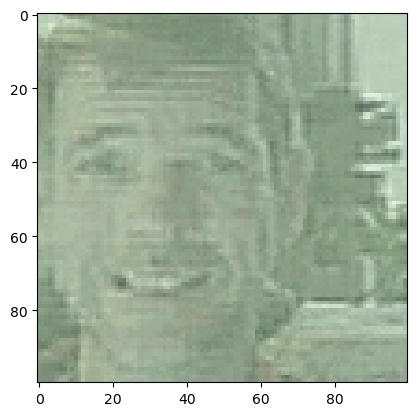

In [276]:
plt.imshow(samp2[1]) # anchor image

In [277]:
if samp2[2] < 1 :
    print ('those images do not match: ' + str(samp2[2]))
else:
    print ('those images do match: ' + str(samp2[2]))

those images do match: 1.0


In [278]:
print('there are '+ str(len(dataset)) +' items in our dataset')
print('  50% of that is: ' + str(round(len(dataset)*.5)) )
print('  70% of that in our train_data: ' + str(round(len(dataset)*.7)) )
print('  30% of that in our test_data: ' + str(round(len(dataset)*.3)) )

there are 600 items in our dataset
  50% of that is: 300
  70% of that in our train_data: 420
  30% of that in our test_data: 180


In [279]:
dataset

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [280]:
# Assuming `dataset` is your _PrefetchDataset object
element_spec = dataset.element_spec

# Extracting the shape from the first TensorSpec in element_spec
shape = element_spec[0].shape

# Converting the shape to a string

print(' dataset has ' + str(len(dataset)) + ' items')
print(' dataset has ' + str(shape) + ' shape')

 dataset has 600 items
 dataset has (100, 100, 3) shape


In [281]:
# Training partition
# this takes a certain percentage of the data
train_data = []
train_data = dataset.take(round(len(dataset)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [282]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [283]:
# Assuming `dataset` is your _PrefetchDataset object
element_spec = train_data.element_spec

# Extracting the shape from the first TensorSpec in element_spec
shape = element_spec[0].shape

# Converting the shape to a string

print(' train_data has ' + str(shape) + ' shape')

 train_data has (None, 100, 100, 3) shape


In [284]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
print(' we are batching ' + str(len(train_sample[0])) +' images in each sample')

 we are batching 16 images in each sample


In [285]:
# Testing partition
test_data = []
test_data = dataset.skip(round(len(dataset)*.7))
test_data = test_data.take(round(len(dataset)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)
len(test_data)

12

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [286]:
inp = Input(shape=(100,100,3), name='input_image')

In [287]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [288]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [289]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [290]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [291]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [292]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [293]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [294]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D((2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D((2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D((2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=inp, outputs=d1, name='embedding')


embedding = make_embedding()

embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [295]:
# Define the L1Dist layer
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        anchor, positive = inputs
        return tf.abs(anchor - positive)

In [296]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [297]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model

In [298]:
# Define inputs
input_image = Input(name='input_img', shape=(100, 100, 3))
validation_image = Input(name='validation_img', shape=(100, 100, 3))

# Define your layers for generating embeddings
flatten_layer = Flatten()
dense_layer = Dense(4096)

# Assuming `embedding` is a model that generates embeddings
# commented otherwise:
#UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
#  super().__init__(**kwargs)
# embedding = tf.keras.models.Sequential([
#    # Define your layers for generating embeddings
#    tf.keras.layers.Flatten(input_shape=(100, 100, 3)),
#    tf.keras.layers.Dense(4096)
#])

# Generate embeddings
inp_embedding = dense_layer(flatten_layer(input_image))
val_embedding = dense_layer(flatten_layer(validation_image))

# Define the embedding model
embedding_model = Model(inputs=[input_image, validation_image], outputs=[inp_embedding, val_embedding])


In [299]:
# Print model summary
embedding_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 30000)     │          0 │ input_img[0][0],  │
│                     │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 4096)      │ 122,884,0… │ flatten_8[0][0],  │
│                     │                   │            │ flatten_8[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 122,884,096 (468.77 MB)

 Trainable params: 122,884,096 (468.77 MB)

 Non-trainable params: 0 (0.00 B)

In [300]:
# Calculate distances
siamese_layer = L1Dist()

In [301]:
distances = siamese_layer([inp_embedding, val_embedding])

In [302]:
classifier = Dense(1, activation='sigmoid')(distances)

In [303]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [304]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 30000)     │          0 │ input_img[0][0],  │
│                     │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 4096)      │ 122,884,0… │ flatten_8[0][0],  │
│                     │                   │            │ flatten_8[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_7 (L1Dist)  │ (None, 4096)      │          0 │ dense_12[0][0],   │
│                     │                   │            │ dense_12[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │      4,097 │ l1_dist_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 122,888,193 (468.78 MB)

 Trainable params: 122,888,193 (468.78 MB)

 Non-trainable params: 0 (0.00 B)

In [305]:
# Define the make_siamese_model function
def make_siamese_model(embedding):
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    # Generate embeddings for anchor and validation images
    inp_embedding = embedding(input_image)
    val_embedding = embedding(validation_image)
    
    # Siamese distance calculation
    siamese_layer = L1Dist()
    distances = siamese_layer([inp_embedding, val_embedding])
    
    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    # Create and compile the Siamese model
    siamese_model = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
    siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return siamese_model

In [306]:
# Create the Siamese model
siamese_model = make_siamese_model(embedding)

siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_8 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │      4,097 │ l1_dist_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [307]:
from tensorflow.keras.optimizers import Adam

In [308]:
# Define the optimizer and loss
# Adam optimizer, there are others... google optimizers for keras
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_object = tf.keras.losses.BinaryCrossentropy()

## 5.2 Establish Checkpoints

In [309]:
# if something screws up training
# this directory will be created if it does not exist
checkpoint_dir = './training_checkpoints'
#ckpt-1.data-00000-of-00001
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [310]:
test_batch = train_data.as_numpy_iterator()

In [311]:
batch_1 = test_batch.next()

In [312]:
print( 'there are : ' + str(len(batch_1[0])) + ' elements in our batch_1')

there are : 16 elements in our batch_1


In [313]:
x_batch = batch_1[:2]

In [314]:
# x_batch

In [315]:
y_batch = batch_1[2]

In [316]:
y_batch

array([0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.],
      dtype=float32)

In [317]:
#tf.losses.BinaryCrossentropy??

## 5.4 Build Training Loop

In [318]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [319]:
@tf.function
def train_step(batch):
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        x_batch = batch[:2]
        # Get label
        y_batch = batch[2]
        
        # Forward pass
        yhat = siamese_model(x_batch, training=True)
        # Calculate loss
        loss = loss_object(y_batch, yhat)
        
    # Calculate gradients wrt this loss for all training_variables
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [320]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [321]:
# Example dataset creation
batch_size = 16
EPOCHS = 50

In [322]:
len(train_data)

27

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 

# 6. Evaluate Model

## 6.1 Import Metrics

In [204]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [205]:
# Get a batch of test data
# we are using test_data rather than train_data now
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [206]:
test_var = test_data.as_numpy_iterator().next()
len(test_var)
print ('16 different samples: ' + str(len(test_var[0])) )
print ('labels: ' + str(len(test_var[2])) )

16 different samples: 16
labels: 16


In [207]:
## Map preprocessing function to each element in the dataset
# test_data = data.map(preprocess_image)

In [208]:
## Batch and prefetch the dataset
# test_data = data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [209]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [210]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


In [132]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

NameError: name 'y_hat' is not defined

In [133]:
# this is taken from above: test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_true

array([1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [134]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result having a precision of 1 is good
m.result().numpy()

NameError: name 'y_hat' is not defined

In [135]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result having a precision of 1 is good
m.result().numpy()

NameError: name 'y_hat' is not defined

In [136]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
0.85294116 0.58


## 6.4 Viz Results

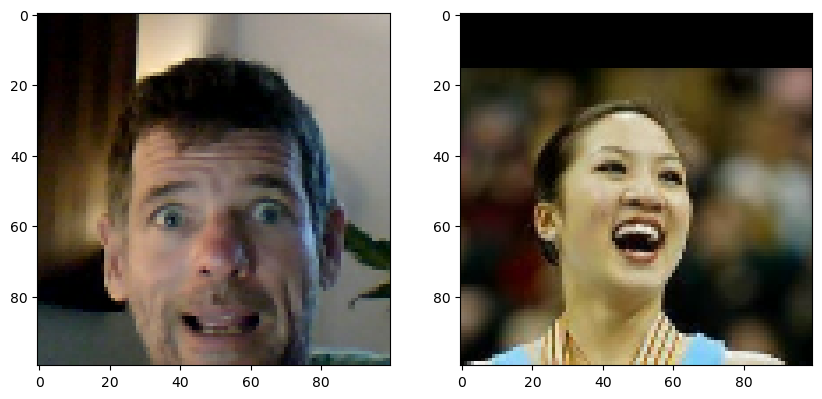

In [211]:
ELEMENT_TO_CHECK=9 #up to 12
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[ELEMENT_TO_CHECK])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[ELEMENT_TO_CHECK])

# Renders cleanly
plt.show()

# 7. Save Model

In [138]:
# Save weights
name_to_save='siamesemodelv5'
siamese_model.save(name_to_save + '.h5')
siamese_model.save(name_to_save + '.keras')

In [212]:
L1Dist

__main__.L1Dist

# 7.1 Load Model

In [213]:
# Reload model 
siamese_model = tf.keras.models.load_model(name_to_save + '.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [214]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.5002031 ],
       [0.500769  ],
       [0.49992862],
       [0.50124097],
       [0.50036776],
       [0.50063986],
       [0.5009804 ],
       [0.49903837],
       [0.49964902],
       [0.5009721 ],
       [0.4996946 ],
       [0.49943706],
       [0.50081885],
       [0.49979854],
       [0.50185466],
       [0.49992666]], dtype=float32)

In [215]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,547 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# 8. Real Time Test

## 8.1 Verification Function

In [216]:
#application_data\verification_images

In [217]:
print('There are ' + str(len(os.listdir(os.path.join('application_data', 'verification_images')))) + ' images in the verification images dir')

There are 50 images in the verification images dir


In [218]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [219]:
# Unccomment to list the file paths
#for image in os.listdir(os.path.join('application_data', 'verification_images')):
#    validation_img = os.path.join('application_data', 'verification_images', image)
#    print(validation_img)

In [241]:
#ok

def verify(model, detection_threshold, verification_threshold):
    # Build results array
    input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
    verification_images_dir = os.path.join('application_data', 'verification_images')
    results = []
    for image in os.listdir(verification_images_dir):
        validation_img = preprocess(os.path.join(verification_images_dir, image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(verification_images_dir))
    verified = verification > verification_threshold
    
    return results, verified

In [240]:
#ok

def verify2(model, detection_threshold=0.6, validation_threshold=0.6, clip_threshold=0.999):
    input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
    verification_images_dir = os.path.join('application_data', 'verification_images')
    results = []
    for image in os.listdir(verification_images_dir):
        validation_img = preprocess(os.path.join(verification_images_dir, image))
        
        # Make Predictions 
        #result = model.predict([np.expand_dims(input_img, axis=1), np.expand_dims(validation_img, axis=0)])
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        
        # Clip result to avoid very high values
        clipped_result = np.clip(result, 0, clip_threshold)
        
        results.append(clipped_result)
    
    results = np.array(results)
    
    detection = np.sum(results > detection_threshold)
    verification = detection / len(os.listdir(verification_images_dir))
    verified = verification > validation_threshold
    
    return results, verified


## 8.2 OpenCV Real Time Verification

In [249]:
#ok  -> verify2  0.49 0.6
import shutil
# Initialize the webcam
print( "info: opening webcam capture on: " + str(WEBCAM) )
print("usage: with the cursor in focus on the webcam window, press:")
print("       v) to verify capture")
print("       q) to quit")

cap = cv2.VideoCapture(WEBCAM)
try:
    while cap.isOpened(): 
        ret, frame = cap.read()
        
        if not ret:
            print("problem: Failed to grab frame from webcam")
            break
        
        # Cut down frame to 250x250pxqqqqqqq
        frame = frame[120:120+250,200:200+250, :]
        
		# Show image back to screen
        cv2.imshow('Verification Capture', frame)
		
        # Collect verification image 
        if cv2.waitKey(1) & 0xFF == ord('v'):
            # Save input image to application_data/input_image folder 
            cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
            # Run verification
            results, verified = verify2(siamese_model, detection_threshold=0.49, validation_threshold=0.6, clip_threshold=0.999999)
 
            print(f"results: {results[0]}")
            print(f"verified: {verified}")
            #print(verified)
            image_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
            # Define the target directories
            true_dir = os.path.join('application_data', 'true')
            false_dir = os.path.join('application_data', 'false')

            # Ensure the directories exist
            os.makedirs(true_dir, exist_ok=True)
            os.makedirs(false_dir, exist_ok=True)

            # Determine the target directory based on the verification result
            target_dir = true_dir if verified else false_dir

            # Define the target file path
            target_path = os.path.join(target_dir, '{}.jpg'.format(uuid.uuid4().int))
            #target_path = os.path.join(target_dir, 'input_image.jpg')

            # Copy the image to the target directory
            shutil.copy(image_path, target_path)
            if verified:
                print(f"true image copied to {target_path}")
                #print(scores)
            else:
                print(f"false Image copied to {target_path}")
                #print(scores)

        # Breaking gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

except Exception as e:
    print( "problem: could not process the webcam.")
    print(f"An error occurred: {e}")
finally:
    # Release the webcam
    cap.release()
    # Close the image show frame
    cv2.destroyAllWindows()

info: opening webcam capture on: 1
usage: with the cursor in focus on the webcam window, press:
       v) to verify capture
       q) to quit
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


In [243]:
#ok  -> verify 0.5 0.6
# Initialize the webcam
print( "info: opening webcam capture on: " + str(WEBCAM) )
print("usage: with the cursor in focus on the webcam window, press:")
print("       v) to gather INPUT images")
print("       q) to quit")

cap = cv2.VideoCapture(WEBCAM)
try:
    while cap.isOpened(): 
        ret, frame = cap.read()
        
        if not ret:
            print("problem: Failed to grab frame from webcam")
            break
        
        # Cut down frame to 250x250px
        frame = frame[120:120+250,200:200+250, :]
        
		# Show image back to screen
        cv2.imshow('Verification', frame)
		
        # Collect verification image 
        if cv2.waitKey(1) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)
#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
          cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
          # Run verification
          results, verified = verify(siamese_model, 0.5, 0.6)
          print(verified)
          # Extracting the result value
          if isinstance(results, list) and len(results) > 0:
              result_value = results[0][0][0] if isinstance(results[0], list) and len(results[0]) > 0 else results[0]
              print("Result value1:", result_value)
          elif isinstance(results, np.ndarray):
              result_value = results[0, 0, 0]
              print("Result value2:", result_value)
          else:
              print("Unable to extract result value from results:", results)

        # Breaking gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
except Exception as e:
    print( "problem: could not process the webcam.")
    print(f"An error occurred: {e}")
finally:
    # Release the webcam
    cap.release()
    # Close the image show frame
    cv2.destroyAllWindows()

info: opening webcam capture on: 1
usage: with the cursor in focus on the webcam window, press:
       v) to gather INPUT images
       q) to quit
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/

In [244]:
#ok  -> verify 0.9 0.7
# Initialize the webcam
print( "info: opening webcam capture on: " + str(WEBCAM) )
print("usage: with the cursor in focus on the webcam window, press:")
print("       v) to gather INPUT images")
print("       q) to quit")

cap = cv2.VideoCapture(WEBCAM)
try:
    while cap.isOpened(): 
        ret, frame = cap.read()
        
        if not ret:
            print("problem: Failed to grab frame from webcam")
            break
        
        # Cut down frame to 250x250px
        frame = frame[120:120+250,200:200+250, :]
        
		# Show image back to screen
        cv2.imshow('Verification', frame)
		
        # Collect verification image 
        if cv2.waitKey(1) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)
#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
          cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
          # Run verification
          results, verified = verify(siamese_model, 0.9, 0.7)
          print(verified)
          # Extracting the result value
          if isinstance(results, list) and len(results) > 0:
              result_value = results[0][0][0] if isinstance(results[0], list) and len(results[0]) > 0 else results[0]
              print("Result value1:", result_value)
          elif isinstance(results, np.ndarray):
              result_value = results[0, 0, 0]
              print("Result value2:", result_value)
          else:
              print("Unable to extract result value from results:", results)

        # Breaking gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
except Exception as e:
    print( "problem: could not process the webcam.")
    print(f"An error occurred: {e}")
finally:
    # Release the webcam
    cap.release()
    # Close the image show frame
    cv2.destroyAllWindows()

info: opening webcam capture on: 1
usage: with the cursor in focus on the webcam window, press:
       v) to gather INPUT images
       q) to quit
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/

In [245]:
np.squeeze(results) > 0.5

array([ True, False,  True, False, False, False,  True,  True,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True, False,  True, False,
       False, False,  True, False, False,  True,  True,  True, False,
        True])

In [246]:
np.sum(np.squeeze(results) > 0.9)

0

In [247]:
print(str(np.sum(np.squeeze(results))))

27.51817
